In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from keras.utils import to_categorical

In [2]:
def merge_history(models):
	data = dict()
	models_copy = models.copy()

	keys = list(models_copy[0].history.keys())
	values = list(models_copy[0].history.values())
	for i in range(len(keys)):
		data[keys[i]] = values[i]
	
	models_copy.pop(0)
	
	for el in models_copy:
		keys = list(el.history.keys())
		values = list(el.history.values())
		for i in range(len(keys)):
			for value in values[i]:
				data[keys[i]].append(value)
	return data

def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if isinstance(model,list):
		istoric = merge_history(model)
		if validation == True:
			val_to_plot = [istoric["val_"+el] for el in labels]
		to_plot = [istoric[el] for el in labels]
	else:
		if validation == True:
			val_to_plot = [model.history["val_"+el] for el in labels]
		to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [3]:
date = pd.read_csv("data/train.csv",delimiter=",")

Y = np.array(date[date.columns[0]].tolist())
Y = to_categorical(Y)

date = date.drop(['label'],axis=1)

X = np.array(date.values.tolist())/255.0
X = np.array([np.reshape(el,(28,28)) for el in X])
#X = np.array([np.reshape(el,(28,28,1)) for el in X])

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=35000,shuffle=True)

del date
del X
del Y

#plot_imagini_demo(train_X,train_Y,28)

In [4]:
print(test_X.shape)
print(test_Y.shape)
print(train_X.shape)
print(train_Y.shape)

(7000, 28, 28)
(7000, 10)
(35000, 28, 28)
(35000, 10)


In [5]:
print(train_X[:5])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [6]:
print(train_Y[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [7]:
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
	tf.keras.metrics.Precision(name='precision'),
	tf.keras.metrics.Recall(name='recall')
]
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, strides=2,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

In [8]:
hist = model.fit(train_X,train_Y,epochs=16,batch_size=64,validation_data=(test_X,test_Y))

Epoch 1/16
547/547 [==============================] - 27s 13ms/step - loss: 0.1581 - accuracy: 0.9909 - precision: 0.9658 - recall: 0.9429 - val_loss: 0.0714 - val_accuracy: 0.9957 - val_precision: 0.9828 - val_recall: 0.9739
Epoch 2/16
547/547 [==============================] - 7s 12ms/step - loss: 0.0591 - accuracy: 0.9965 - precision: 0.9847 - recall: 0.9800 - val_loss: 0.0394 - val_accuracy: 0.9976 - val_precision: 0.9884 - val_recall: 0.9871
Epoch 3/16
547/547 [==============================] - 7s 12ms/step - loss: 0.0432 - accuracy: 0.9972 - precision: 0.9878 - recall: 0.9846 - val_loss: 0.0248 - val_accuracy: 0.9985 - val_precision: 0.9934 - val_recall: 0.9911
Epoch 4/16
547/547 [==============================] - 7s 12ms/step - loss: 0.0381 - accuracy: 0.9976 - precision: 0.9896 - recall: 0.9868 - val_loss: 0.0297 - val_accuracy: 0.9981 - val_precision: 0.9910 - val_recall: 0.9899
Epoch 5/16
547/547 [==============================] - 7s 13ms/step - loss: 0.0343 - accuracy: 0.997

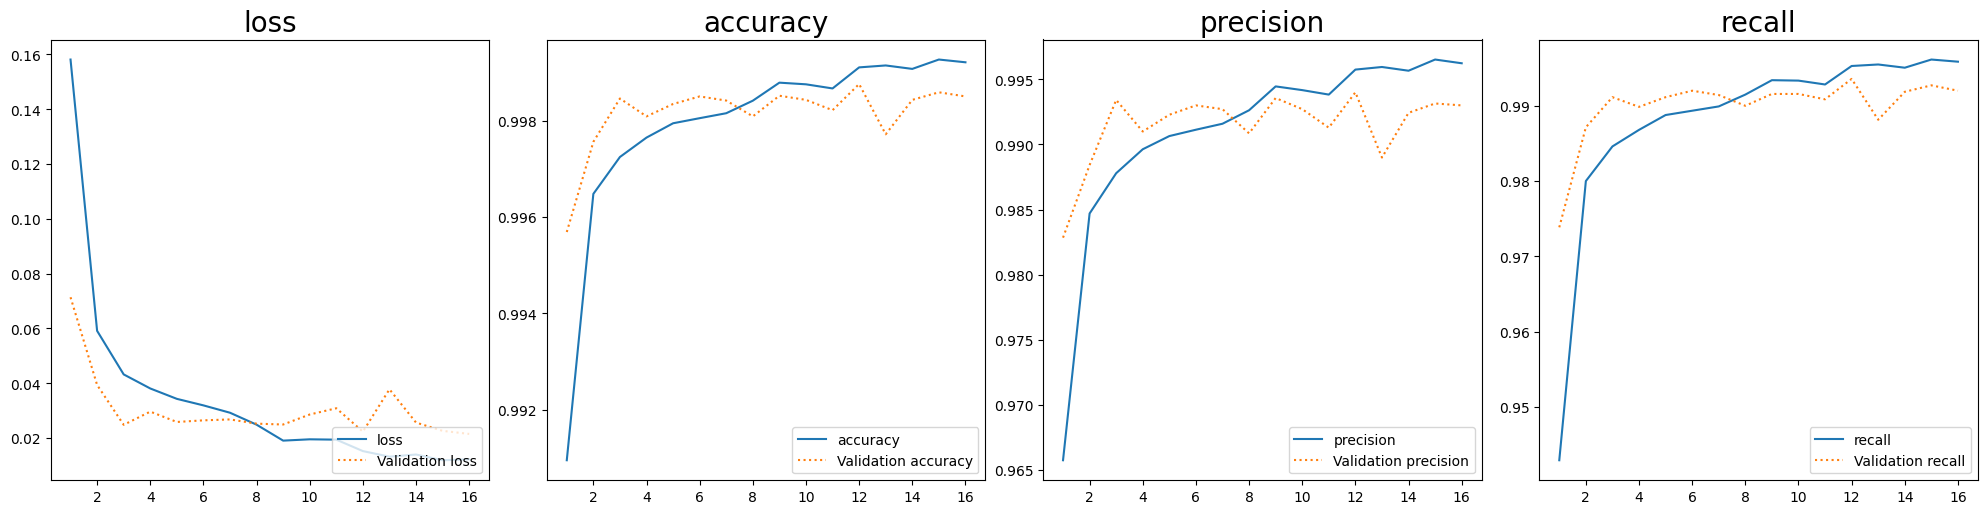

In [9]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)

219/219 [==============================] - 1s 2ms/step
Accuracy:  0.9922857142857143
Precision:  0.99218549061693
Recall:  0.9922372500083714
F1 Score:  0.992205957300461


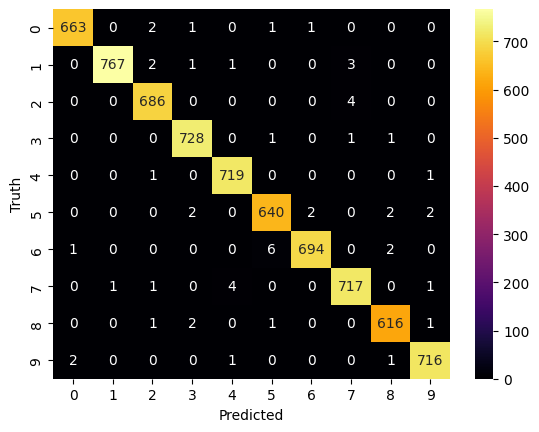

In [10]:
predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in predicted]
actual = [np.argmax(el) for el in test_Y]

print("Accuracy: ",accuracy_score(actual,predicted))
print("Precision: ",precision_score(actual,predicted,average="macro"))
print("Recall: ",recall_score(actual,predicted,average="macro"))
print("F1 Score: ",f1_score(actual,predicted,average="macro"))

cm = confusion_matrix(actual, predicted)
sn.heatmap(cm, annot=True, fmt='d',cmap="inferno")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [11]:
date_test = pd.read_csv("data/test.csv",delimiter=",")
test_X = np.array(date_test.values.tolist())/255.0
test_X = np.array([np.reshape(el,(28,28)) for el in test_X])

y_predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in y_predicted]

results = pd.Series(predicted,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),results],axis=1)
submission.to_csv("output.csv",index=False)


875/875 [==============================] - 2s 2ms/step


# Final score on kaggle
Score: 0.99128